In [1]:
import numpy as np

import random
import h5py
from nn_util import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.initializers import *
import tensorflow

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = "Symbola"
matplotlib.rcParams['font.size'] = 12
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

from keras.activations import softmax

# increase recursion limit for adaptive VQ
import sys
sys.setrecursionlimit(40000)

np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

Using TensorFlow backend.


In [2]:
# control amount of GPU memory used
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [3]:
import consts
consts.NBINS = 5
consts.BINS_INIT = np.linspace(-1.0, 1.0, consts.NBINS)
consts.QUANT_BINS = K.variable(consts.BINS_INIT, name = 'QUANT_BINS')

In [4]:
# external custom code I wrote
from load_data import *
from windowing import *
from pesq import *
from consts import *
from nn_blocks import *
from perceptual_loss import *
from evaluation import *

In [5]:
orig_input = [[0, 0, 2, 3, 4, 5], [5, 2, 0, 2, 5, 5], [5, 5, 2, 2, 0, 0], [5, 0, 0, 0, 0, 5]]
x = K.variable(orig_input)

nb = 3
bins_init = [0, 2, 5]
adapt_step = 3

# change_scales is: [NBINS]
change_scales = K.variable(np.ones(nb))

init_state = K.variable(bins_init)

# x is a vector: [BATCH_SIZE x ADAPT_STEP]
# curr_bins is a vector: [BATCH_SIZE x NBINS]
def my_enc_step(x, curr_bins):
    # ------------------------------------
    # compute output
    # ------------------------------------
    # x_r becomes: [BATCH_SIZE x ADAPT_STEP x 1]
    x_r = K.expand_dims(x, -1)
    
    # c_r becomes: [BATCH_SIZE x 1 x NBINS]
    c_r = K.expand_dims(curr_bins, -2)
    
    # get L1 distance from each element to each of the bins
    # dist is: [BATCH_SIZE x ADAPT_STEP x NBINS]
    dist = K.abs(x_r - c_r)
    
    # turn into softmax probabilities, which we return
    # probs is: [BATCH_SIZE x ADAPT_STEP x NBINS]
    probs = softmax(500 * -dist)
    
    # ------------------------------------
    # update bins
    # ------------------------------------
    
    # symbol_probs is: [BATCH_SIZE x NBINS]
    symbol_probs = K.sum(probs, axis = 1) / adapt_step
    
    # curr_change_scale is: [BATCH_SIZE x 1]
    curr_change_scale = K.dot(symbol_probs, K.expand_dims(change_scales))
    
    # new_bins is: [BATCH_SIZE x NBINS x 1]
    new_bins = K.batch_dot(K.expand_dims(curr_bins), K.expand_dims(curr_change_scale))
    
    # new_bins is: [BATCH_SIZE x NBINS]
    new_bins = K.squeeze(new_bins, -1)
    
    # ------------------------------------
    # return output + new bins
    # ------------------------------------
    return probs, new_bins

init_state = K.expand_dims(init_state, 0)
tile_amt = [tf.shape(x)[0]]
tile_amt = tf.concat([tile_amt, tf.ones((1,), dtype = tf.int32)], axis = 0)
init_state = tf.tile(init_state, tile_amt)

x = K.expand_dims(x)

mod_x = K.reshape(x, (-1, x.shape[1] / adapt_step, adapt_step))
mod_x = tf.transpose(mod_x, [1, 0, 2])
mod_x = tf.unstack(mod_x)

bins = init_state
out = []
for i in mod_x:
    w, bins = my_enc_step(i, bins)
    out.append(w)

enc = tf.stack(out)
enc = tf.transpose(enc, [1, 0, 2, 3])
enc = K.reshape(enc, (-1, enc.shape[1] * enc.shape[2], enc.shape[3]))

print K.eval(enc)

[[[1.000000 0.000000 0.000000]
  [1.000000 0.000000 0.000000]
  [0.000000 1.000000 0.000000]
  [0.000000 1.000000 0.000000]
  [0.000000 0.000000 1.000000]
  [0.000000 0.000000 1.000000]]

 [[0.000000 0.000000 1.000000]
  [0.000000 1.000000 0.000000]
  [1.000000 0.000000 0.000000]
  [0.000000 1.000000 0.000000]
  [0.000000 0.000000 1.000000]
  [0.000000 0.000000 1.000000]]

 [[0.000000 0.000000 1.000000]
  [0.000000 0.000000 1.000000]
  [0.000000 1.000000 0.000000]
  [0.000000 1.000000 0.000000]
  [1.000000 0.000000 0.000000]
  [1.000000 0.000000 0.000000]]

 [[0.000000 0.000000 1.000000]
  [1.000000 0.000000 0.000000]
  [1.000000 0.000000 0.000000]
  [1.000000 0.000000 0.000000]
  [1.000000 0.000000 0.000000]
  [0.000000 0.000000 1.000000]]]


In [6]:
x = enc

init_state = K.variable(bins_init)

# x is a vector of size [BATCH_SIZE x ADAPT_STEP x NBINS] -- 1 time step
# curr_bins is a vector [BATCH_SIZE x NBINS]
def my_dec_step(x, curr_bins):
    # compute out value
    out = K.batch_dot(x, K.expand_dims(curr_bins, 2))
    out = K.squeeze(out, -1)

    # TODO: compute new bins
    new_bins = curr_bins

    return out, new_bins


init_state = K.expand_dims(init_state, 0)
tile_amt = [tf.shape(x)[0]]
tile_amt = tf.concat([tile_amt, tf.ones((1,), dtype = tf.int32)], axis = 0)
init_state = tf.tile(init_state, tile_amt)

mod_x = K.reshape(x, (-1, x.shape[1] / adapt_step, adapt_step, x.shape[2]))
mod_x = tf.unstack(tf.transpose(mod_x, [1, 0, 2, 3]))

bins = init_state
out = []
for i in mod_x:
    w, bins = my_dec_step(i, bins)
    out.append(w)
    
dec = tf.stack(out)
dec = tf.transpose(dec, [1, 0, 2])
dec = K.reshape(dec, (-1, dec.shape[1] * adapt_step))

print "Decoded"
print K.eval(dec)
print""
print "Original"
print orig_input

Decoded
[[0.000000 0.000000 2.000000 2.000000 5.000000 5.000000]
 [5.000000 2.000000 0.000000 2.000000 5.000000 5.000000]
 [5.000000 5.000000 2.000000 2.000000 0.000000 0.000000]
 [5.000000 0.000000 0.000000 0.000000 0.000000 5.000000]]

Original
[[0, 0, 2, 3, 4, 5], [5, 2, 0, 2, 5, 5], [5, 5, 2, 2, 0, 0], [5, 0, 0, 0, 0, 5]]


In [7]:
ADAPT_STEP = 16
CHANGE_SCALES = K.variable(np.ones(NBINS))
CHANGE_BIASES = K.variable(np.zeros(NBINS))

In [8]:
# quantization: takes in    [BATCH x WINDOW_SIZE]
#               and returns [BATCH x WINDOW_SIZE x NBINS]
# where the last dimension is a one-hot vector of bins
#
# [bins initialization is in consts.py]
class AdaptiveQuantization(Layer):
    def build(self, input_shape):
        self.SOFTMAX_TEMP = K.variable(500.0, name = 'softmax_temp')
        self.trainable_weights = [QUANT_BINS,
                                  CHANGE_SCALES,
                                  self.SOFTMAX_TEMP]
        super(AdaptiveQuantization, self).build(input_shape)
    
    # x is a vector: [BATCH_SIZE x ADAPT_STEP]
    # curr_bins is a vector: [BATCH_SIZE x NBINS]
    def step(self, x, curr_bins):
        # ------------------------------------
        #  compute output
        # ------------------------------------
        # x_r becomes: [BATCH_SIZE x ADAPT_STEP x 1]
        x_r = K.expand_dims(x, -1)

        # c_r becomes: [BATCH_SIZE x 1 x NBINS]
        c_r = K.expand_dims(curr_bins, -2)

        # get L1 distance from each element to each of the bins
        # dist is: [BATCH_SIZE x ADAPT_STEP x NBINS]
        dist = K.abs(x_r - c_r)

        # turn into softmax probabilities, which we return
        # probs is: [BATCH_SIZE x ADAPT_STEP x NBINS]
        probs = softmax(self.SOFTMAX_TEMP * -dist)

        # ------------------------------------
        #  update bins
        # ------------------------------------
        # symbol_probs is: [BATCH_SIZE x NBINS]
        symbol_probs = K.sum(probs, axis = 1) / ADAPT_STEP

        # curr_change_scale is: [BATCH_SIZE x 1]
        # curr_change_bias is: [BATCH_SIZE x 1]
        curr_change_scale = K.dot(symbol_probs, K.expand_dims(CHANGE_SCALES))
        curr_change_bias = K.dot(symbol_probs, K.expand_dims(CHANGE_BIASES))

        # new_bins is: [BATCH_SIZE x NBINS x 1], then [BATCH_SIZE x NBINS]
        new_bins = K.batch_dot(K.expand_dims(curr_bins), K.expand_dims(curr_change_scale))
        new_bins = K.squeeze(new_bins, -1)
        new_bins = new_bins + curr_change_bias

        # ------------------------------------
        #  return output + new bins
        # ------------------------------------
        return probs, new_bins
    
    def call(self, x, mask = None):
        # a really contrived way to repeat QUANT_BINS into a vector
        #     BATCH_SIZE x NBINS
        # because Keras's TF backend doesn't support tensor arguments for
        # repeat_elements
        curr_bins = K.expand_dims(QUANT_BINS, 0)
        tile_amt = [tf.shape(x)[0]]
        tile_amt = tf.concat([tile_amt, tf.ones((1,), dtype = tf.int32)], axis = 0)
        curr_bins = tf.tile(curr_bins, tile_amt)
        
        # out becomes: list of length [WINDOW_SIZE / ADAPT_STEP]
        #                  of BATCH_SIZE x ADAPT_STEP x NBINS length testors
        mod_x = K.reshape(x, (-1, x.shape[1] / ADAPT_STEP, ADAPT_STEP))
        mod_x = tf.unstack(tf.transpose(mod_x, [1, 0, 2]))
        out = []
        for i in mod_x:
            w, new_bins = self.step(i, curr_bins)
            curr_bins = new_bins
            out.append(w)
        
        # we finagle this into: [BATCH_SIZE x WINDOW_SIZE x NBINS]
        enc = tf.transpose(tf.stack(out), [1, 0, 2, 3])
        enc = K.reshape(enc, (-1, enc.shape[1] * enc.shape[2], NBINS))
        return enc
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], NBINS)

In [9]:
# dequantization: takes in    [BATCH x WINDOW_SIZE x NBINS]
#                 and returns [BATCH x WINDOW_SIZE]
class AdaptiveDequantization(Layer):
    # x is a vector of size [BATCH_SIZE x ADAPT_STEP x NBINS] -- 1 time step
    # curr_bins is a vector [BATCH_SIZE x NBINS]
    def step(self, x, curr_bins):
        # ------------------------------------
        #  compute output
        # ------------------------------------
        out = K.batch_dot(x, K.expand_dims(curr_bins, 2))
        out = K.squeeze(out, -1)
        
        # ------------------------------------
        #  update bins
        # ------------------------------------
        # symbol_probs is: [BATCH_SIZE x NBINS]
        symbol_probs = K.sum(x, axis = 1) / ADAPT_STEP

        # curr_change_scale is: [BATCH_SIZE x 1]
        # curr_change_bias is: [BATCH_SIZE x 1]
        curr_change_scale = K.dot(symbol_probs, K.expand_dims(CHANGE_SCALES))
        curr_change_bias = K.dot(symbol_probs, K.expand_dims(CHANGE_BIASES))

        # new_bins is: [BATCH_SIZE x NBINS x 1], then [BATCH_SIZE x NBINS]
        new_bins = K.batch_dot(K.expand_dims(curr_bins), K.expand_dims(curr_change_scale))
        new_bins = K.squeeze(new_bins, -1)
        new_bins = new_bins + curr_change_bias
        
        # ------------------------------------
        #  return output + new bins
        # ------------------------------------
        return out, new_bins
        
    def call(self, x, mask=None):
        nbatch = K.int_shape(x)[0]
        
        curr_bins = K.expand_dims(QUANT_BINS, 0)
        tile_amt = [tf.shape(x)[0]]
        tile_amt = tf.concat([tile_amt, tf.ones((1,), dtype = tf.int32)], axis = 0)
        curr_bins = tf.tile(curr_bins, tile_amt)
        
        mod_x = K.reshape(x, (-1, x.shape[1] / ADAPT_STEP, ADAPT_STEP, x.shape[2]))
        mod_x = tf.unstack(tf.transpose(mod_x, [1, 0, 2, 3]))
        out = []
        for i in mod_x:
            w, new_bins = self.step(i, curr_bins)
            curr_bins = new_bins
            out.append(w)
            
        dec = tf.transpose(tf.stack(out), [1, 0, 2])
        dec = K.reshape(dec, (-1, dec.shape[1] * ADAPT_STEP))
        return dec
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

In [10]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [11]:
# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE, 1))

# randomly shuffle data, if we want to
if (RANDOM_SHUFFLE):
    train_processed = np.random.permutation(train_processed)
    
print train_processed.shape
print np.mean(train_processed, axis=None)
print np.std(train_processed, axis=None)
print np.min(train_processed, axis = None)
print np.max(train_processed, axis = None)

X_train = np.copy(train_processed)

(101544, 512, 1)
-2.40941e-06
0.104158
-1.0
1.0


# Adaptive Quantization

In [12]:
input_dim = (WINDOW_SIZE, 1)
model_input = Input(shape = input_dim)

enc_input = Input(shape = input_dim)
enc = Reshape((WINDOW_SIZE, 1))(enc_input)
enc = AdaptiveQuantization()(enc)
enc = Model(inputs = enc_input, outputs = enc)

dec_input = Input(shape = (WINDOW_SIZE, NBINS))
dec = AdaptiveDequantization()(dec_input)
dec = Reshape((WINDOW_SIZE, 1))(dec)
dec = Model(inputs = dec_input, outputs = dec)

model_reconstructed = dec(enc(model_input))
model = Model(inputs = [model_input], outputs = [model_reconstructed] * 2)

n_losses = 2
losses = [rmse, perceptual_distance]
weights = [30.0, 1.0]

model.compile(loss = losses,
              loss_weights = weights,
              optimizer = Adam())
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_1 (Model)              (None, 512, 5)            11.0      
_________________________________________________________________
model_2 (Model)              (None, 512, 1)            0         
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:1511: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'model_2/reshape_2/Reshape:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_2/reshape_2/Reshape:0' shape=(?, 512, 1) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

In [14]:
def fancy_plot(x, y = None, yl = (-1.25, 1.25), dots = False, axes = True):
    if (axes):
        plt.axhline(0, color = 'gray')
        plt.axvline(0, color = 'gray')

    if (dots):
        sc = '.'
        ms = 3
    else:
        sc = '-'
        ms = 2
    
    if (y is not None):
        plt.plot(x, y, sc, ms = ms)
    else:
        plt.plot(x, sc, ms = ms)
    plt.grid()
    
    if (yl is not None):
        plt.ylim(yl[0], yl[1])
        
    if (y is None):
        plt.xlim(0, len(x))
        
    plt.show()

## Before training

In [15]:
test_model_on_wav("./SA1.wav", "SA1_quant_before", model)

MSE:         96657.9
Avg err:     190.109
PESQ:        1.02987837791


[96657.906, 190.10916, 1.0298783779144287]

Original


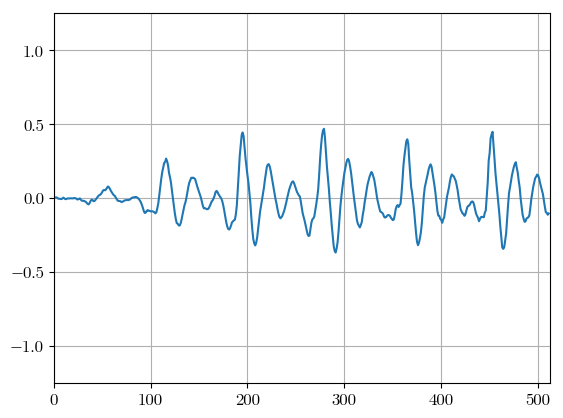

Reconstruction


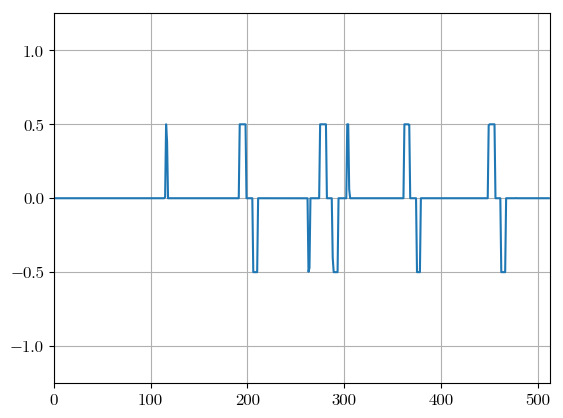

In [16]:
idx = 52

orig = X_train[idx].flatten()
recn = model.predict(X_train[idx:idx+1], verbose = 0)[0].flatten()

print "Original"
fancy_plot(orig, axes = False)

print "Reconstruction"
fancy_plot(recn, axes = False)

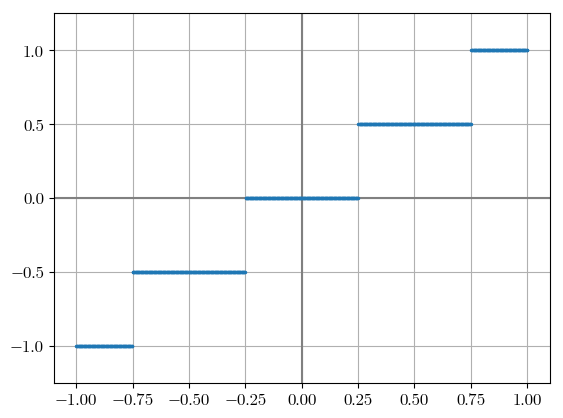

In [17]:
x = np.linspace(-1.0, 1.0, 800)

bins = K.eval(QUANT_BINS)
y = [bins[np.argmin(np.abs(bins - num))] for num in x]
fancy_plot(x, y, dots = True)

## After training

In [18]:
model.fit(X_train, [X_train] * n_losses, verbose = 1, epochs = 5, batch_size = 128)

Epoch 1/5
101544/101544 [==============================] - 17s - loss: 2.5506 - model_2_loss_1: 0.0213 - model_2_loss_2: 1.9115    
Epoch 2/5
101544/101544 [==============================] - 16s - loss: 2.1501 - model_2_loss_1: 0.0168 - model_2_loss_2: 1.6461    
Epoch 3/5
101544/101544 [==============================] - 16s - loss: 2.0790 - model_2_loss_1: 0.0168 - model_2_loss_2: 1.5760    
Epoch 4/5
101544/101544 [==============================] - 16s - loss: 2.0759 - model_2_loss_1: 0.0168 - model_2_loss_2: 1.5718    
Epoch 5/5
101544/101544 [==============================] - 16s - loss: 2.0756 - model_2_loss_1: 0.0168 - model_2_loss_2: 1.5722    


In [19]:
test_model_on_wav("./SA1.wav", "SA1_quant_after", model)

MSE:         21997.7
Avg err:     59.8505
PESQ:        1.40691828728


[21997.66, 59.850452, 1.4069182872772217]

Original


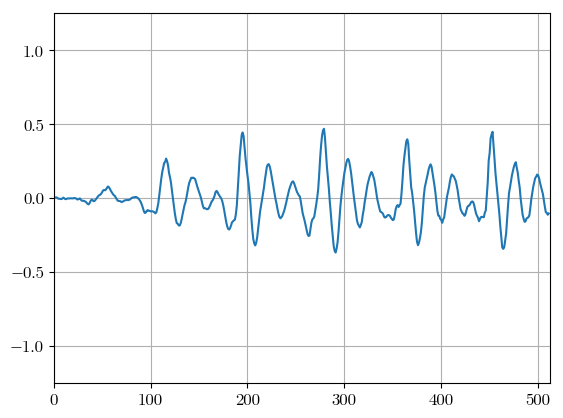

Reconstruction


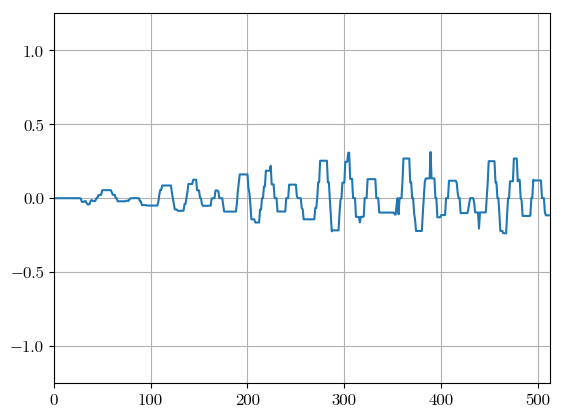

In [20]:
idx = 52

orig = X_train[idx].flatten()
recn = model.predict(X_train[idx:idx+1], verbose = 0)[0].flatten()

print "Original"
fancy_plot(orig, axes = False)

print "Reconstruction"
fancy_plot(recn, axes = False)

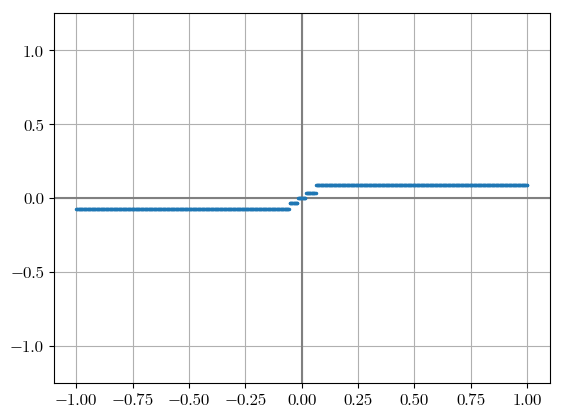

In [21]:
x = np.linspace(-1.0, 1.0, 800)

bins = K.eval(QUANT_BINS)
y = [bins[np.argmin(np.abs(bins - num))] for num in x]
fancy_plot(x, y, dots = True)